# Scalers comparison - Supervised
In this notebook I'll compare three common scalers to see the effect on the classification

In [1]:
# Importing main libraries
import matplotlib
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from benchtools.src.clustering import build_features
from benchtools.src.datatools import separate_data
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from benchtools.src.datatools import separate_data

# Importing the metrics
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score, balanced_accuracy_score, roc_auc_score, average_precision_score

# Importing the classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Getting the data

I'll pre-process the data using the <code>benchtools</code> package. The next cell just need to be run one time

In [2]:
build_features(path_data='..\..\events_anomalydetection.h5', nbatch=10, outname='RD_dataset')

A file with that name already exists


In [3]:
# Importing the data 
df = pd.read_csv("..\data\RD_dataset.csv")
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


Since it's just to test on scalers I'll do it on a smaller sample

In [4]:
# Eliminate the columns of mass so that the training is model-free 
df_RD = df.sample(100000, random_state = 1).drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
df_RD.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons,label
264511,1636.540865,0.224496,-2.373993,1729.163350,0.371356,118,1547.619954,1.162014,0.710714,2722.719214,0.377317,59,3.224028,228.0,0.0
446040,1700.570450,-1.046567,-0.074009,2722.693611,0.173263,20,1471.042986,-0.496909,-3.102066,1660.217227,0.931903,39,3.077540,89.0,1.0
367350,1209.240264,1.501579,3.008941,2849.555797,0.693441,20,1192.250774,1.114281,-0.051151,2015.636945,0.527644,33,3.084503,86.0,0.0
510497,1331.228201,0.991312,2.934796,2041.150095,0.746076,13,1206.745736,0.501046,-0.197147,1366.214578,0.967665,54,3.170083,122.0,0.0
301480,1229.918669,-0.947064,2.870159,1828.159257,0.918211,39,1226.020830,0.063516,-0.261698,1238.924198,0.873326,42,3.290866,109.0,0.0


I'll define a function to scale the data

In [5]:
def scale_data(data, scaler=None):
    # Getting the variables 
    X, y = separate_data(data, standarize=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
    
    if scaler is not None:   
        #Scaling
        X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
        X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])
    
    
    return X_train, y_train, X_test, y_test

And another one to train the algorithms

In [6]:
def supervised_training(classifiers, X_train, y_train, X_test, y_test):
    log_dict = {}
    #log_cols = ["Classifier", "Precision", "Recall", "Log loss", "F1 score", 
    #            "Balanced accuracy", "AUC score", "Average precision"]
    #log = pd.DataFrame(columns=log_cols)
    
    for clf in tqdm(classifiers):
    #for clf in classifiers:

        # Training the classifiers
        clf.fit(X_train, y_train)
        
        # Getting its names
        name = clf.__class__.__name__
    
        # Obtaining predictions
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)

        # Calculating metrics
        precision = precision_score(y_test, y_pred)
        ll = log_loss(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        ba = balanced_accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob[:, 1])
        ap = average_precision_score(y_test, y_prob[:, 1])

        # Inserting into a dictionary
        log_dict[name]=[recall, precision*100, ll, f1, ba, auc, ap]
    
    # Converting it to a dataframe
    columns_name = {0:'Recall', 1:'Precision', 2:'Log Loss', 3: 'F1 score',
              4:'Balanced accuracy', 5:'AUC score', 6: 'Average precision'}
    log = pd.DataFrame.from_dict(log_dict, orient='index').rename(columns=columns_name)
    log.index.name = 'Classifier'
    return log

Lastly, this is the list of supervised algorithms that will be trained

In [7]:
# Listing the classifiers to compare
classifiers = [LogisticRegression(max_iter=600),
                KNeighborsClassifier(3, weights='distance'),
                SVC(kernel="rbf", C=0.025, probability=True),
                DecisionTreeClassifier(criterion="entropy", max_depth=3),
                RandomForestClassifier(),
                AdaBoostClassifier(),
                GradientBoostingClassifier(),
                GaussianNB(),
                LinearDiscriminantAnalysis(),
                QuadraticDiscriminantAnalysis(), 
                MLPClassifier()]

## Training
### Without scaling

In [8]:
X_train, y_train, X_test, y_test = scale_data(df_RD)
log_ns = supervised_training(classifiers, X_train, y_train, X_test, y_test)

  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero

### MinMaxScaler

In [9]:
X_train, y_train, X_test, y_test = scale_data(df_RD, MinMaxScaler())
log_mms = supervised_training(classifiers, X_train, y_train, X_test, y_test)

  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### StandardScaler

In [10]:
X_train, y_train, X_test, y_test = scale_data(df_RD, StandardScaler())
log_ss = supervised_training(classifiers, X_train, y_train, X_test, y_test)

  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### RobustScaler

In [11]:
X_train, y_train, X_test, y_test = scale_data(df_RD, RobustScaler())
log_rs = supervised_training(classifiers, X_train, y_train, X_test, y_test)

  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Comparison

I want to plot each variable comparing the result for each classifier.

In [12]:
# Concat with multiindex
df = pd.concat([log_ns, log_mms, log_ss, log_rs], axis=1, keys=['None','MinMax', 'Standard', 'Robust'])
df

None                                 \
                                 Recall  Precision  Log Loss  F1 score   
Classifier                                                               
LogisticRegression             0.429099  69.873722  0.179878  0.531686   
KNeighborsClassifier           0.357459  47.802469  1.399440  0.409043   
SVC                            0.000000   0.000000  0.240304  0.000000   
DecisionTreeClassifier         0.395864  66.625233  0.194890  0.496641   
RandomForestClassifier         0.573855  84.871655  0.155526  0.684732   
AdaBoostClassifier             0.549114  71.905222  0.646865  0.622697   
GradientBoostingClassifier     0.584934  80.202532  0.134632  0.676489   
GaussianNB                     0.661743  52.290633  0.241418  0.584189   
LinearDiscriminantAnalysis     0.477474  65.801527  0.184492  0.553392   
QuadraticDiscriminantAnalysis  0.631832  69.187222  0.163295  0.660490   
MLPClassifier                  0.000000   0.000000  0.704400  0.000000   

                                                                             \
                              Balanced accuracy AUC score Average precision   
Classifier                                                                    
LogisticRegression                     0.705371  0.919259          0.571622   
KNeighborsClassifier                   0.659365  0.770520          0.339359   
SVC                                    0.500000  0.840558          0.452609   
DecisionTreeClassifier                 0.688094  0.889351          0.482188   
RandomForestClassifier                 0.781853  0.952409          0.783813   
AdaBoostClassifier                     0.763913  0.940696          0.697300   
GradientBoostingClassifier             0.785303  0.955799          0.776292   
GaussianNB                             0.800918  0.913170          0.579343   
LinearDiscriminantAnalysis             0.726426  0.920537          0.544531   
QuadraticDiscriminantAnalysis          0.801956  0.938673          0.720182   
MLPClassifier                          0.500000  0.896375          0.579331   

                                 MinMax                       ...  \
                                 Recall  Precision  Log Loss  ...   
Classifier                                                    ...   
LogisticRegression             0.413589  70.886076  0.180182  ...   
KNeighborsClassifier           0.604136  70.853183  0.906204  ...   
SVC                            0.350443  84.656557  0.165063  ...   
DecisionTreeClassifier         0.414328  62.576687  0.199186  ...   
RandomForestClassifier         0.505170  84.863524  0.159477  ...   
AdaBoostClassifier             0.507755  72.482868  0.638345  ...   
GradientBoostingClassifier     0.529173  81.652422  0.142128  ...   
GaussianNB                     0.644387  52.719033  0.247184  ...   
LinearDiscriminantAnalysis     0.482644  65.480962  0.187157  ...   
QuadraticDiscriminantAnalysis  0.586780  71.867933  0.174209  ...   
MLPClassifier                  0.597489  83.187661  0.126270  ...   

                                       Standard                              \
                              Balanced accuracy AUC score Average precision   
Classifier                                                                    
LogisticRegression                     0.704613  0.919041          0.578361   
KNeighborsClassifier                   0.808617  0.883673          0.637432   
SVC                                    0.727489  0.936296          0.732459   
DecisionTreeClassifier                 0.686651  0.889067          0.484475   
RandomForestClassifier                 0.780727  0.951435          0.782460   
AdaBoostClassifier                     0.761325  0.940690          0.696173   
GradientBoostingClassifier             0.784359  0.955698          0.775900   
GaussianNB                             0.800211  0.913693          0.579418   
LinearDiscriminantAnalysis             0.722398  0.9205

### For each classifier

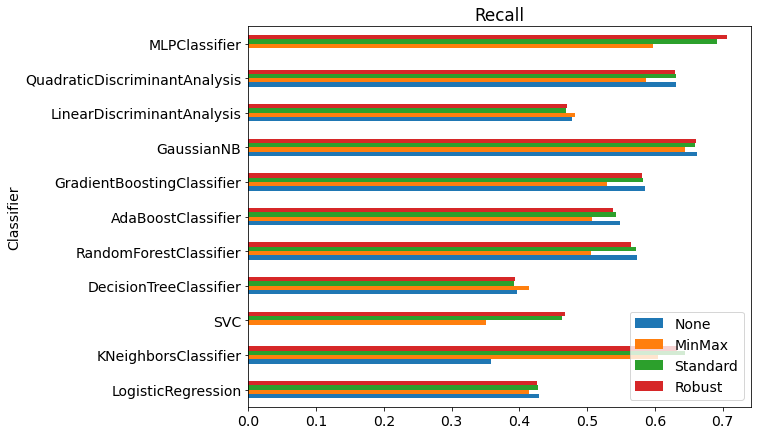

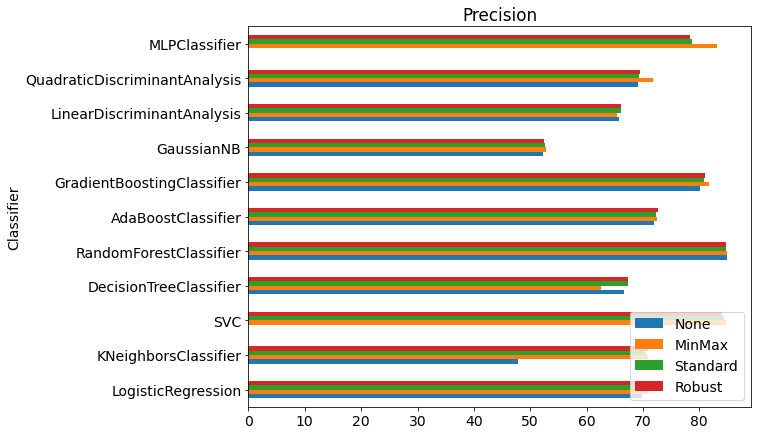

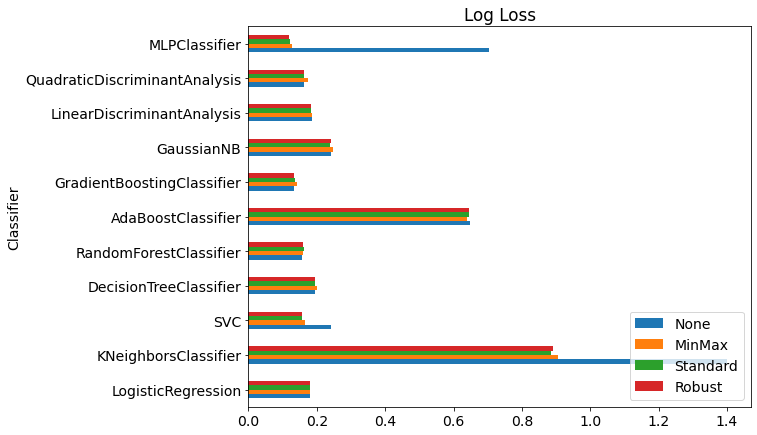

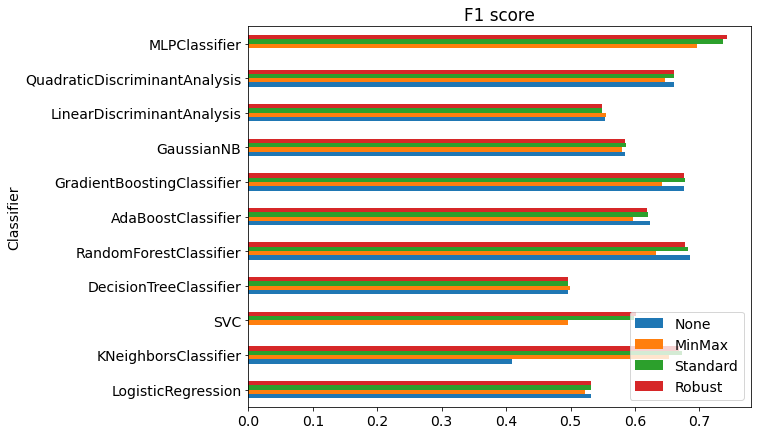

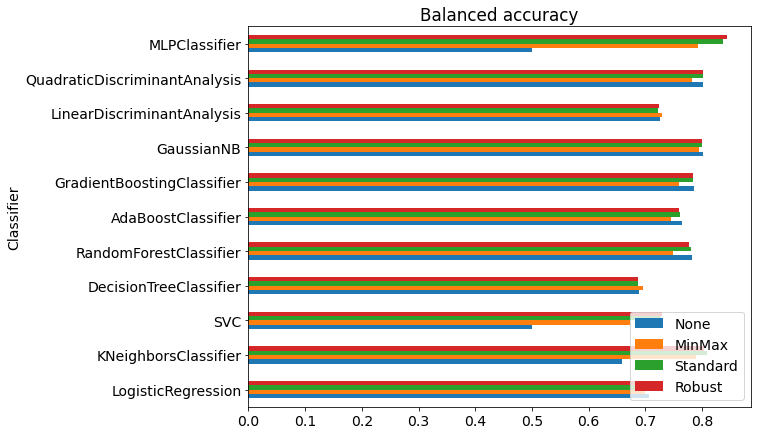

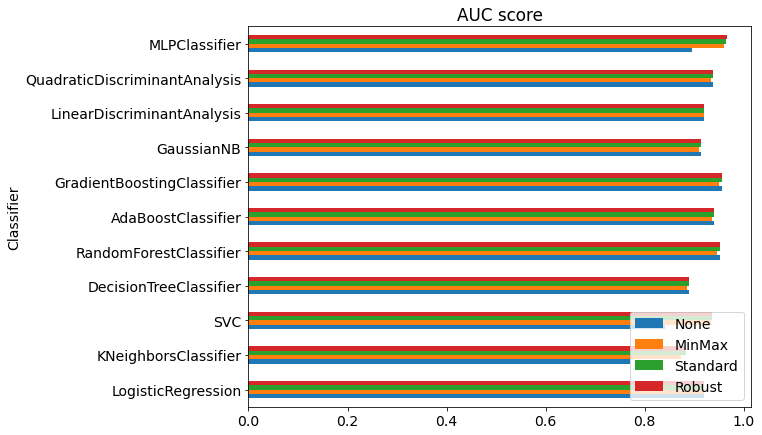

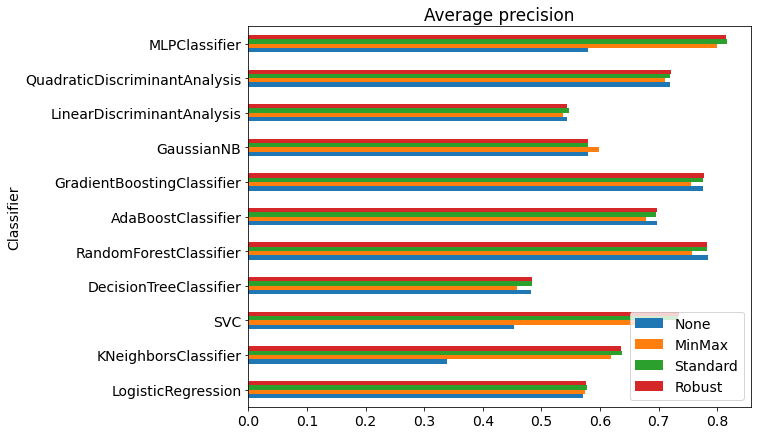

In [13]:
columns = log_mms.columns.tolist()

for variable in columns:
    matplotlib.rcParams.update({'font.size': 14})
    df.iloc[:, df.columns.get_level_values(1)==variable].plot.barh(figsize=(9,7), title=variable)
    plt.legend(['None','MinMax', 'Standard', 'Robust'], loc="lower right")
    plt.show()

Here we see that the best scaler isn't universal, it depends on the classifier. With the mean of the values we can see a more general comparison.
### In general

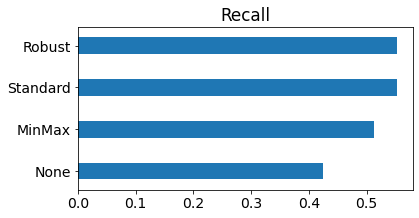

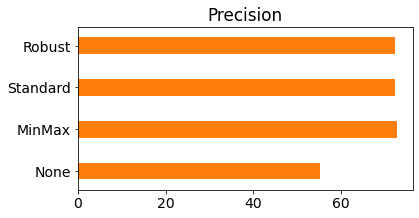

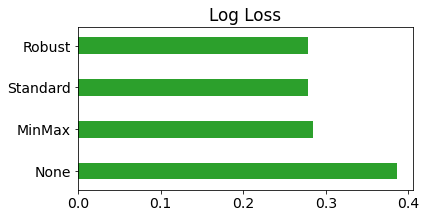

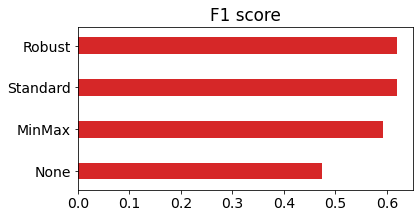

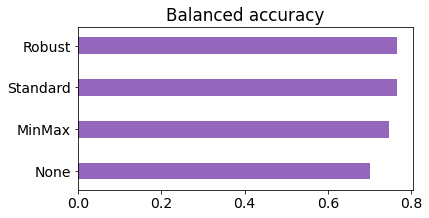

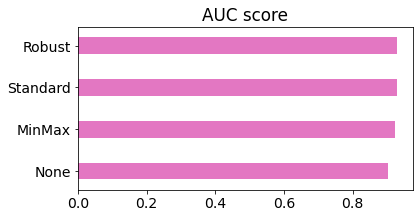

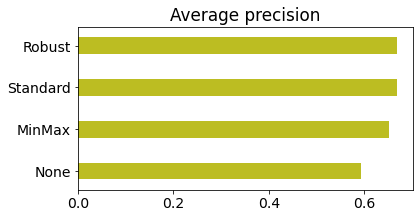

In [14]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:olive', 'tab:cyan']
for variable, color in zip(columns, color_list):  
    df.mean().loc[:,variable].plot.barh(figsize=(6,3), color=color, title=variable, stacked=True, width=0.4)
    plt.show()

In general, the metrics for RobustScaler and StandardScaler are very close. Both of them are better than MinMaxScaler and overall is better to scale the data.

However, since I'll be using only three of four classifiers I will choose between StandardScaler and RobustScaler based on which is better for each one in particular.